## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [138]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
#nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

In [139]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [140]:
# Opening JSON file 
f = open('/content/drive/MyDrive/complaints-2021-05-14_08_16.json', 'r') # Write the path to your data file and load it 
  
# returns JSON object as  
# a dictionary 
data = json.load(f)
df=pd.json_normalize(data)

## Data preparation

In [141]:
# Inspect the dataframe to understand the given data.
df.sample(5)


,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,_source.consumer_disputed,_source.product,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
15795,complaint-public-v2,complaint,2833789,0.0,"Older American, Servicemember",852XX,2833789,Trouble during payment process,2018-03-05T12:00:00-05:00,AZ,N/A,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Web,2018-03-05T12:00:00-05:00,None,Conventional home mortgage,Yes,"In XX/XX/XXXX, we paid Chase Mortgage {$100.00} ( item 2 ) from our savings account to recast our existing 30 year mortgage. We did this at the branch with our banker XXXX, ( item 2 ). XXXX was o...",None,Consent provided
15051,complaint-public-v2,complaint,3224825,0.0,Servicemember,460XX,3224825,Improper use of your report,2019-04-27T12:00:00-05:00,IN,N/A,"Credit reporting, credit repair services, or other personal consumer reports",Closed with non-monetary relief,JPMORGAN CHASE & CO.,Web,2019-04-27T12:00:00-05:00,None,Credit reporting,Yes,My idenity was compromised while I was overseer serving in the U.S. Military between XXXX - XXXX. During this time Chase Auto and Chase Card but a unauthorized hard inquiry on my credit report. I ...,Credit inquiries on your report that you don't recognize,Consent provided
9200,complaint-public-v2,complaint,227193,0.0,None,92618,227193,"Loan modification,collection,foreclosure",2013-01-10T12:00:00-05:00,CA,No,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Web,2013-01-11T12:00:00-05:00,None,Conventional adjustable mortgage (ARM),Yes,,None,N/A
3769,complaint-public-v2,complaint,2569498,0.0,None,328XX,2569498,Improper use of your report,2017-07-09T12:00:00-05:00,FL,N/A,"Credit reporting, credit repair services, or other personal consumer reports",Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-07-09T12:00:00-05:00,None,Credit reporting,Yes,"There are XXXX hard inquiries on my credit report from the same company : XXXX. The inquiries are 3 days apart.One in XXXX XXXX, 2017 and one XXXX XXXX, 2017. There 's also XXXX inquiry from Chase...",Credit inquiries on your report that you don't recognize,Consent provided
53969,complaint-public-v2,complaint,1619558,0.0,None,336XX,1619558,Other,2015-10-22T12:00:00-05:00,FL,Yes,Credit card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2015-10-27T12:00:00-05:00,None,None,Yes,"I have an account with Chase Bank that has been in delinquent status over 7 years ; however, Chase Bank continues to report that the account is still within the 7 year statue of limitation by movi...",None,Consent provided


In [142]:
#print the column names
print(df.columns)

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')


In [143]:
import re

In [144]:
'''def replace_name(col_name):
  if re.search('[_source.]{1}',col_name):
    return col_name[8:] + '1st block'
  elif re.search('_{1}',col_name):
    return col_name[1:]  
  else:
    return col_name'''


def replace_name(col_name):
  if '_source.' in col_name:
    return col_name[8:]
  elif '_' in col_name:
    return col_name[1:] 
  else:
    return col_name

In [145]:
#Assign new column names
cols = list(df.columns )
for col in cols:
  print(col + '===========>>>' + replace_name(col))

_index===========>>>index
_type===========>>>type
_id===========>>>id
_score===========>>>score
_source.tags===========>>>tags
_source.zip_code===========>>>zip_code
_source.complaint_id===========>>>complaint_id
_source.issue===========>>>issue
_source.date_received===========>>>date_received
_source.state===========>>>state
_source.consumer_disputed===========>>>consumer_disputed
_source.product===========>>>product
_source.company_response===========>>>company_response
_source.company===========>>>company
_source.submitted_via===========>>>submitted_via
_source.date_sent_to_company===========>>>date_sent_to_company
_source.company_public_response===========>>>company_public_response
_source.sub_product===========>>>sub_product
_source.timely===========>>>timely
_source.complaint_what_happened===========>>>complaint_what_happened
_source.sub_issue===========>>>sub_issue
_source.consumer_consent_provided===========>>>consumer_consent_provided


In [146]:
#Changing the column names of the dataframe
for col in cols:
  df.rename(columns={col:replace_name(col)},inplace=True)

#Print the new column names
print(df.columns)

Index(['index', 'type', 'id', 'score', 'tags', 'zip_code', 'complaint_id',
       'issue', 'date_received', 'state', 'consumer_disputed', 'product',
       'company_response', 'company', 'submitted_via', 'date_sent_to_company',
       'company_public_response', 'sub_product', 'timely',
       'complaint_what_happened', 'sub_issue', 'consumer_consent_provided'],
      dtype='object')


In [147]:
df.sample(5)

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,consumer_disputed,product,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
28350,complaint-public-v2,complaint,3099472,0.0,None,074XX,3099472,Fees or interest,2018-12-12T12:00:00-05:00,NJ,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2018-12-18T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Problem with fees,N/A
31386,complaint-public-v2,complaint,2571666,0.0,None,908XX,2571666,Closing an account,2017-07-12T12:00:00-05:00,CA,N/A,Checking or savings account,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-07-12T12:00:00-05:00,None,Checking account,Yes,I went to cash a check. I was informed that my account was closed and could not be reopened. The banker at the bank stated he had never heard of this before. So he called and the informed him and ...,Company closed your account,Consent provided
56303,complaint-public-v2,complaint,166073,0.0,None,95492,166073,Billing disputes,2012-10-04T12:00:00-05:00,CA,No,Credit card,Closed with monetary relief,JPMORGAN CHASE & CO.,Referral,2012-10-09T12:00:00-05:00,None,None,Yes,,None,N/A
69499,complaint-public-v2,complaint,3024902,0.0,None,None,3024902,Struggling to pay mortgage,2018-09-20T12:00:00-05:00,None,N/A,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Phone,2018-09-25T12:00:00-05:00,None,Other type of mortgage,Yes,,None,N/A
39621,complaint-public-v2,complaint,1554222,0.0,None,11758,1554222,Billing disputes,2015-09-07T12:00:00-05:00,NY,Yes,Credit card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2015-09-07T12:00:00-05:00,None,None,Yes,,None,Consent not provided


In [148]:
#Check the percentage of null data for each column
round(100*df.isnull().sum()/len(df),2)

index                         0.00
type                          0.00
id                            0.00
score                         0.00
tags                         86.08
zip_code                      8.63
complaint_id                  0.00
issue                         0.00
date_received                 0.00
state                         2.54
consumer_disputed             0.00
product                       0.00
company_response              0.00
company                       0.00
submitted_via                 0.00
date_sent_to_company          0.00
company_public_response      99.99
sub_product                  13.50
timely                        0.00
complaint_what_happened       0.00
sub_issue                    59.12
consumer_consent_provided     1.29
dtype: float64

In [149]:
#Check the rows with more than 80% data as null
len(df[round(100*df.isnull().sum(axis=1)/len(df.columns),2) >= 80.00])

0

In [150]:
df.shape

(78313, 22)

In [151]:
#Number of records with blank value as complaint
len(df[df.complaint_what_happened.str.strip() == ''])

57241

In [152]:
#Assign nan in place of blanks in the complaints column
df.complaint_what_happened.replace('',np.NaN,inplace=True)

In [153]:
#Cross check if any blanks are remaining
len(df[df.complaint_what_happened.str.strip() == ''])

0

In [154]:
#Remove all rows where complaints column is nan
df = df[~(df.complaint_what_happened.isna())]
len(df)

21072

In [155]:
#Check the percentage of null data for each column
round(100*df.isnull().sum()/len(df),2)

index                         0.00
type                          0.00
id                            0.00
score                         0.00
tags                         81.89
zip_code                     22.04
complaint_id                  0.00
issue                         0.00
date_received                 0.00
state                         0.68
consumer_disputed             0.00
product                       0.00
company_response              0.00
company                       0.00
submitted_via                 0.00
date_sent_to_company          0.00
company_public_response      99.99
sub_product                  10.01
timely                        0.00
complaint_what_happened       0.00
sub_issue                    38.80
consumer_consent_provided     0.00
dtype: float64

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Use POS tags to get relevant words from the texts.


In [156]:
# Write your function here to clean the text and remove all the unnecessary elements.
def cleanText(text):
  text = text.lower()   #Make the text lowercase
  text = re.sub(r'[\(\[].*?[\)\]]', '', text)  #Remove text in square brackets
  text = re.sub(r'[^\w\s]', '', text)  #Remove punctuation
  text = re.sub(r'[0-9]', '', text)  #Remove words containing numbers
  return text

In [159]:
#Verifying that the above function is working correctly
testData = "ABC's assignMent [No.] iS pending! 22Acres [aabcd ee]"
print(cleanText(testData))
#print(re.findall('\[.*?\]', testData))

abcs assignment  is pending acres 


In [160]:
#nltk.download('punkt')
#nltk.download('stopwords')
#nltk.download('wordnet')

#from nltk.stem import WordNetLemmatizer
#from nltk.tokenize import word_tokenize
#from nltk.corpus import stopwords

from spacy.lang.en.stop_words import STOP_WORDS

nlp = spacy.load("en_core_web_sm")

In [161]:
print(STOP_WORDS)
print('Number of stopwords = ', len(STOP_WORDS))

{'both', 'fifteen', 'within', 'rather', 'least', 'herself', 'thereafter', 'to', 'yourselves', 'no', 'besides', 'alone', 'for', 'until', 'hundred', "'ll", 'all', 'among', 'still', 'noone', 'each', 'whether', 'few', 'such', 'very', 'none', 'so', 'almost', 'two', 'above', 'nor', 'hereupon', 'whole', 'and', 'something', 'about', 'then', 'enough', 'via', 'had', 'over', 'between', 'doing', 'anyhow', 'namely', 'anyone', 'before', 're', 'under', 'ours', 'into', 'seeming', 'this', 'everywhere', 'part', "'re", 'wherein', 'thru', 'itself', 'yet', 'elsewhere', 'onto', 'which', "'m", 'what', 'behind', 'never', 'ever', 'front', 'nobody', '’s', 'back', 'are', 'when', 'him', 'moreover', 'while', 'except', 'them', 'why', 'wherever', 'other', 'seems', 'of', 'though', 'bottom', 'nothing', 'somehow', 'nowhere', 'every', 'it', 'thence', 'already', 'five', 'you', '’d', 'unless', 'made', 'himself', 'neither', 'twenty', 'nevertheless', 'several', 'becoming', 'off', 'due', 'name', 'a', 'meanwhile', 'does', 'al

In [162]:
#Write your function to Lemmatize the texts
def lemmatizeText(text):
  text = cleanText(text)
  doc = nlp(text)
  #Tokenize
  #tokens = word_tokenize(text)

  #Get lemma
  #wordnet_lemmatizer = WordNetLemmatizer()
  lemmatized = [token.lemma_ for token in doc]

  #Remove stop words
  cleanTokens = [token for token in lemmatized if token not in set(STOP_WORDS)]

  #Joining back to sentence
  text = ' '.join(lemmatized)

  return text

In [163]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
df_clean = pd.DataFrame(columns = {'complaints', 'complaints_lemma'})
df_clean['complaints'] = df['complaint_what_happened']
df_clean['complaints_lemma'] = df_clean.complaints.apply(lambda x:lemmatizeText(x))

In [164]:
df_clean.head()

,complaints_lemma,complaints
1,good morning -PRON- name be xxxx xxxx and i appreciate -PRON- if -PRON- could help -PRON- put a stop to chase bank cardmember service \n in i write to chase ask for debt verification and what -P...,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent ...
2,i upgrade -PRON- xxxx xxxx card in xxxx and be tell by the agent who do the upgrade -PRON- anniversary date would not change -PRON- turn the agent be give -PRON- the wrong information in order to ...,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to u...
10,chase card be report on xxxx however fraudulent application have be submit -PRON- identity without -PRON- consent to fraudulently obtain service do not extend credit without verify the identity of...,"Chase Card was reported on XX/XX/2019. However, fraudulent application have been submitted my identity without my consent to fraudulently obtain services. Do not extend credit without verifying th..."
11,on xxxx while try to book a xxxx xxxx ticket i come across an offer for to be apply towards the ticket if i apply for a reward card i put in -PRON- information for the offer and within less ...,"On XX/XX/2018, while trying to book a XXXX XXXX ticket, I came across an offer for {$300.00} to be applied towards the ticket if I applied for a rewards card. I put in my information for the off..."
14,-PRON- grand son give -PRON- check for i deposit -PRON- into -PRON- chase account after fund clear -PRON- chase bank close -PRON- account never pay -PRON- -PRON- money -PRON- say -PRON- need to ...,my grand son give me check for {$1600.00} i deposit it into my chase account after fund clear my chase bank closed my account never paid me my money they said they need to speek with my grand son ...


In [165]:
#Write your function to extract the POS tags 
def getNouns(text):
  doc = nlp(text)
  nouns = []
  for token in doc:
    if token.pos_ == 'NOUN':
      nouns.append(token.text)
  return ' '.join(nouns)


In [166]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean['complaint_POS_removed'] = df_clean['complaints_lemma'].apply(lambda x:getNouns(x))
df_clean.head()

,complaints_lemma,complaints,complaint_POS_removed
1,good morning -PRON- name be xxxx xxxx and i appreciate -PRON- if -PRON- could help -PRON- put a stop to chase bank cardmember service \n in i write to chase ask for debt verification and what -P...,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent ...,morning name stop bank cardmember service debt verification statement bank debt mail month debt right information consumer chase account advance help
2,i upgrade -PRON- xxxx xxxx card in xxxx and be tell by the agent who do the upgrade -PRON- anniversary date would not change -PRON- turn the agent be give -PRON- the wrong information in order to ...,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to u...,card agent anniversary date agent information order account change anniversary date consent xxxx recording agent
10,chase card be report on xxxx however fraudulent application have be submit -PRON- identity without -PRON- consent to fraudulently obtain service do not extend credit without verify the identity of...,"Chase Card was reported on XX/XX/2019. However, fraudulent application have been submitted my identity without my consent to fraudulently obtain services. Do not extend credit without verifying th...",card report application submit identity consent service credit identity applicant
11,on xxxx while try to book a xxxx xxxx ticket i come across an offer for to be apply towards the ticket if i apply for a reward card i put in -PRON- information for the offer and within less ...,"On XX/XX/2018, while trying to book a XXXX XXXX ticket, I came across an offer for {$300.00} to be applied towards the ticket if I applied for a rewards card. I put in my information for the off...",xxxx ticket offer ticket reward card information offer minute screen decision xxxx minute notification screen representative application information offer credit offer account statement use ticket...
14,-PRON- grand son give -PRON- check for i deposit -PRON- into -PRON- chase account after fund clear -PRON- chase bank close -PRON- account never pay -PRON- -PRON- money -PRON- say -PRON- need to ...,my grand son give me check for {$1600.00} i deposit it into my chase account after fund clear my chase bank closed my account never paid me my money they said they need to speek with my grand son ...,son chase account fund account money say son check money -PRON- money son call time check owner country time date xxxx check number claim number


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




(array([6.853e+03, 6.239e+03, 3.473e+03, 1.759e+03, 9.940e+02, 7.100e+02,
        4.710e+02, 1.560e+02, 1.020e+02, 6.600e+01, 4.200e+01, 4.400e+01,
        2.800e+01, 2.200e+01, 2.400e+01, 1.400e+01, 1.500e+01, 5.000e+00,
        8.000e+00, 3.000e+00, 5.000e+00, 5.000e+00, 5.000e+00, 2.000e+00,
        2.000e+00, 2.000e+00, 2.000e+00, 4.000e+00, 0.000e+00, 0.000e+00,
        5.000e+00, 2.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00,
        0.000e+00, 2.000e+00]),
 array([1.900000e+01, 6.508400e+02, 1.282680e+03, 1.914520e+03,
        2.546360e+03, 3.178200e+03, 3.810040e+03, 4.441880e+03,
        5.073720e+03, 5.705560e+03, 6.337400e+03, 6.969240e+03,
        7.601080e+03, 8.232920e+03, 8.864760e+03, 9.496600e+03,
        1.012844e+04, 1.076028e+04, 1.139212e+04, 1.202396e+04,
        1.265580e+04, 1.328764e+04, 1.391948e+04, 1.4551

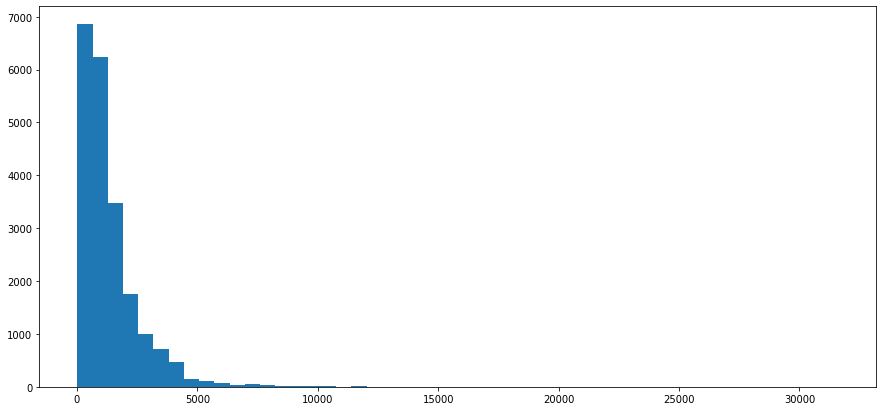

In [167]:
# Write your code here to visualise the data according to the 'Complaint' character length
plt.figure(figsize=(15,7))
lengths = [len(complaint) for complaint in df_clean.complaints]
plt.hist(lengths, bins = 50)

#### Find the top 40 words by frequency among all the articles after processing the text.

In [168]:
from wordcloud import WordCloud

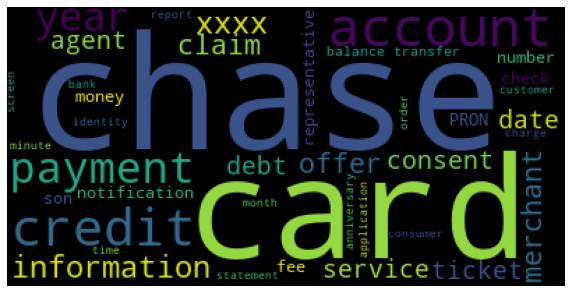

In [169]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
wordcloud = WordCloud(stopwords=STOP_WORDS,max_words=40).generate(str(df_clean.complaint_POS_removed))
print(wordcloud)
plt.figure(figsize=(10,6))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [170]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [171]:
#Function to get top n number of n-grams and their frequency
#Input Parameters:
#     content     => data in a form of a sequence
#     ngram_range => The lower and upper boundary of the range of n-values for different word n-grams
#     numOfWords  => Number of n-grams from top to be extracted, along with their frequency 
def getTopNgramsFreq(content,ngram_range,numOfWords):
  vectorizer = CountVectorizer(ngram_range = ngram_range)
  bagOfWords = vectorizer.fit_transform(content)
  sumOfWords = bagOfWords.sum(axis=0)
  sumOfWords = np.array(sumOfWords).reshape(-1,).tolist()
  words = vectorizer.get_feature_names()
  wordsFrequency = dict(zip(words,sumOfWords))
  wordsFrequency = sorted(wordsFrequency.items(), key = lambda x:x[1], reverse=True)
  return wordsFrequency[:numOfWords]

# print(getTopNgramsFreq(df_clean['Complaint_clean'], (2,2), 10))



In [172]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 
top30_unigrams = getTopNgramsFreq(df_clean.Complaint_clean, (1,1), 30)
for unigram in top30_unigrams:
  print(unigram)

('account', 44970)
('chase', 39166)
('credit', 32339)
('card', 29564)
('payment', 20512)
('xxxx', 16353)
('charge', 15877)
('bank', 15723)
('time', 15676)
('day', 12714)
('money', 11811)
('check', 11639)
('loan', 10311)
('information', 9505)
('letter', 9257)
('report', 8973)
('call', 8812)
('fee', 8535)
('transaction', 8341)
('number', 8309)
('month', 8282)
('amount', 8273)
('year', 8144)
('customer', 8008)
('mortgage', 7918)
('state', 7901)
('claim', 7721)
('balance', 7486)
('phone', 7414)
('company', 7345)


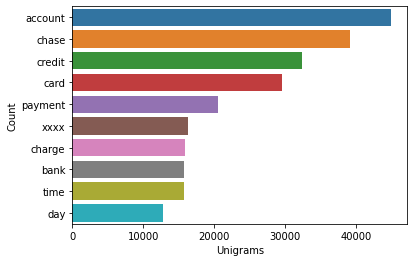

In [173]:
df_temp = pd.DataFrame(top30_unigrams, columns={'Unigrams', 'Count'})
df_temp = df_temp.iloc[:10,:]
sns.barplot(x=df_temp.Unigrams, y=df_temp.Count)

In [174]:
#Print the top 10 words in the unigram frequency
df_temp

,Count,Unigrams
0,account,44970
1,chase,39166
2,credit,32339
3,card,29564
4,payment,20512
5,xxxx,16353
6,charge,15877
7,bank,15723
8,time,15676
9,day,12714


In [175]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 
top30_bigrams = getTopNgramsFreq(df_clean.Complaint_clean, (2,2), 30)

,Bigrams,Count
0,credit card,12325
1,credit report,3860
2,customer service,2838
3,chase credit,2320
4,account account,2257
5,account chase,2252
6,bank account,1894
7,debit card,1827
8,chase account,1747
9,check account,1737


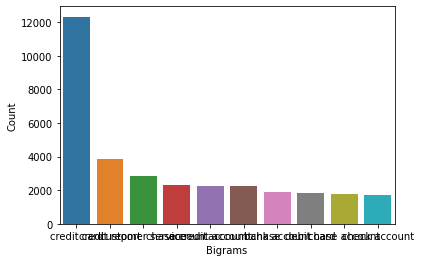

In [176]:
#Print the top 10 words in the bigram frequency
df_temp = pd.DataFrame(top30_bigrams, columns={'Bigrams', 'Count'})
df_temp = df_temp.iloc[:10,:]
sns.barplot(x=df_temp.Bigrams, y=df_temp.Count)
df_temp

In [177]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 
top30_trigrams = getTopNgramsFreq(df_clean.Complaint_clean, (3,3), 30)

,Count,Trigrams
0,chase credit card,1641
1,credit card account,1046
2,credit card company,932
3,credit card credit,516
4,inquiry credit report,510
5,credit card chase,497
6,charge credit card,492
7,card credit card,421
8,account credit card,417
9,credit reporting agency,351


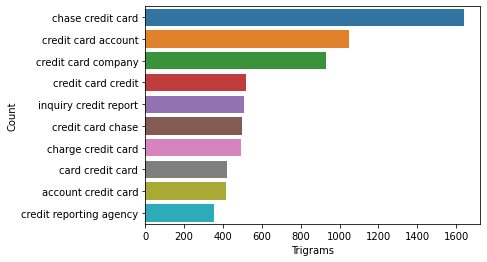

In [178]:
#Print the top 10 words in the trigram frequency
df_temp = pd.DataFrame(top30_trigrams, columns={'Trigrams', 'Count'})
df_temp = df_temp.iloc[:10,:]
sns.barplot(x=df_temp.Trigrams, y=df_temp.Count)
df_temp

## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [179]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [180]:
#Printing top 10 unigrams again to cross check that xxxx has been removed
#It was present in the top 10 unigrams before the previous line of code
for unigram, freq in getTopNgramsFreq(df_clean.Complaint_clean, (1,1), 10):
  print(unigram)

account
chase
credit
card
payment
charge
bank
time
day
money


'xxxx' has been removed

In [181]:
#All masked texts has been removed
df_clean.sample(5)

,complaints_lemma,complaints,complaint_POS_removed,Complaint_clean
62042,-PRON- condominium owner s association be a small association of xxxx condominium unit in xxxx xxxx one of -PRON- owner s stop pay -PRON- monthly due a notice of delinquency be mail to -PRON- on x...,"Our Condominium Owner 's Association is a small association of XXXX condominium units. In XXXX XXXX, one of our owner 's, stopped paying her monthly dues. A Notice of Delinquency was mailed to her...",association unit owner s notice delinquency mail xxxx association home pay month place lien property association resident fix income remain owner shortfall hardship -PRON- need maintenance project...,association unit owner s notice delinquency mail association home pay month place lien property association resident fix income remain owner shortfall hardship need maintenance project expense r...
61397,-PRON- brother and i locate an ad on xxxx offering discount airfare contact the ad be advise that -PRON- could book -PRON- airline ticket at a discount price the other person book -PRON- air provi...,"My brother and I located an ad on XXXX offering discounted airfare. Contacted the ad, was advised that they could book our airline tickets at a discounted price. The other person booked our air, p...",brother ad discount ad airline ticket discount price person book air confirmation number airline brother proof ticket wire bank week ticket book airline fraud contact bank bank recall wire transfe...,brother ad discount ad airline ticket discount price person book air confirmation number airline brother proof ticket wire bank week ticket book airline fraud contact bank bank recall wire transfe...
8844,on xxxxxxxx -PRON- xxxx account be compromise -PRON- gain access to all of -PRON- stored password which include -PRON- bank account credential -PRON- use these credential to gain access to -PRON- ...,On XX/XX/XXXX my XXXX accounts were compromised. They gained access to all of my stored passwords which included my bank account credentials. They used these credentials to gain access to my onlin...,account compromise access password account credential access account purchase total catch chase -PRON- debit card chase situation week amount account fund account chase charge card use phone regis...,account compromise access password account credential access account purchase total catch chase debit card chase situation week amount account fund account chase charge card use phone register ba...
29210,i have a temporary account with chase bank in xxxx of i receive a letter say that a credit card application in -PRON- name be submit on xxxx xxxx and deny because -PRON- be a duplicate applica...,I had a temporary account with Chase Bank ( set up in order to receive a payment from another Chase customer ). In XXXX of 2016 I received a letter saying that a credit card application in my name...,account xxxx letter credit card application name application credit card application submit cust rep card -PRON- fraud investigator day cancel card address bank use information system credit card ...,account letter credit card application name application credit card application submit cust rep card fraud investigator day cancel card address bank use information system credit card instance s...
24828,on xxxxxxxxi respond to a birthday xxxx xxxx page on xxxx for a friend i submit to xxxx xxxx xxxx when the transmission be complete i be charge i immediately contact xxxx xxxx xxxx via xxxx in...,"On XX/XX/XXXXI responded to a Birthday XXXX XXXX page on XXXX for a friend. I submitted {$25.00} to XXXX XXXX XXXX. When the transmission was complete, I was charged {$250.00}. I immediately conta...",birthday page friend transmission charge fund post week call back state contact help center return avail dispute bank weekof transaction question donation refund party complaint donation assistance,birthday page friend transmission charge fund post week call back state contact help center return avail dispute 

## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [182]:
#Write your code here to initialise the TfidfVectorizer 
vect = TfidfVectorizer(stop_words='english',max_df=0.95, min_df=2)

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [183]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
X = vect.fit_transform(df_clean.Complaint_clean)

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [184]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [185]:
#Function to find Top 15 words against each topic, where number of topics can be passed as a parameter
def getTopWordsForTopics(num_topics):
  nmf_model = NMF(num_topics, random_state =40)
  W = nmf_model.fit_transform(X)
  H = nmf_model.components_
  words = np.array(vect.get_feature_names())
  num_top_words = 15
  topic_words_df = pd.DataFrame(np.zeros((num_topics, num_top_words)), 
                                index=[f'Topic {i}' for i in range(num_topics)],
                                columns=[f'Word {i}' for i in range(num_top_words)]).astype(str)

  for i in range(num_topics):
      ix = H[i].argsort()[::-1][:num_top_words]
      topic_words_df.iloc[i] = words[ix]

  return topic_words_df

In [186]:
#Testing for 2 topics
getTopWordsForTopics(2).head()

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,account,check,bank,money,chase,fund,payment,day,transaction,fee,deposit,time,branch,claim,number
Topic 1,credit,card,report,charge,chase,payment,inquiry,company,balance,time,month,letter,score,dispute,year


We can see above that the topics are broadly divided into 'Bank/Accounts' and 'Credit cards' category if we choose to break the data into two clusters. But there might be more patterns which we might be missing out. So we can try increasing the number of topics and see if there is any improvement

In [187]:
#Testing for 3 topics
getTopWordsForTopics(3).head()

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,account,check,money,bank,chase,fund,deposit,transaction,day,fee,branch,claim,charge,number,fraud
Topic 1,credit,card,report,charge,chase,inquiry,company,dispute,balance,score,information,letter,purchase,account,fraud
Topic 2,payment,loan,mortgage,chase,month,modification,home,time,year,rate,balance,property,pay,statement,fee


Now we can see that besides Account and Credit card related complaints, we also have Mortgage related complaints. Let us increase the number of topics further and see the result.

In [188]:
#Testing for 4 topics
getTopWordsForTopics(4).head()

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,account,check,money,bank,fund,chase,deposit,branch,day,number,business,transaction,transfer,claim,customer
Topic 1,credit,card,report,inquiry,account,chase,score,company,information,application,limit,debt,letter,balance,year
Topic 2,payment,loan,mortgage,chase,month,modification,home,time,year,rate,balance,property,pay,statement,date
Topic 3,charge,card,fee,transaction,dispute,chase,merchant,purchase,claim,fraud,service,time,balance,refund,statement


We can see now that Credit Card related complaints can be further divided into two categories - Credit Card services, and Credit Card fraud. Let us now try with 5 topics.

In [189]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5 #write the value you want to test out

#keep the random_state =40
nmf_model = NMF(num_topics, random_state =40)#write your code here

In [190]:
#nmf_model.fit(dtm)
#len(tfidf.get_feature_names())

W = nmf_model.fit_transform(X)
H = nmf_model.components_

In [191]:
#Print the Top15 words for each of the topics
words = np.array(vect.get_feature_names())

num_top_words = 15
topic_words_df = pd.DataFrame(np.zeros((num_topics, num_top_words)), 
                              index=[f'Topic {i}' for i in range(num_topics)],
                              columns=[f'Word {i}' for i in range(num_top_words)]).astype(str)

for i in range(num_topics):
    ix = H[i].argsort()[::-1][:num_top_words]
    topic_words_df.iloc[i] = words[ix]

topic_words_df

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,account,check,money,bank,fund,deposit,chase,branch,day,number,transaction,business,transfer,claim,customer
Topic 1,credit,card,report,inquiry,chase,account,score,company,information,limit,application,debt,letter,year,balance
Topic 2,payment,balance,month,fee,statement,day,pay,time,date,auto,credit,chase,account,year,mortgage
Topic 3,charge,card,fee,transaction,dispute,chase,merchant,purchase,fraud,claim,service,refund,time,statement,balance
Topic 4,loan,mortgage,modification,home,chase,property,year,letter,time,document,rate,sale,foreclosure,house,information


We can observe from the above that the topics numbers can be mapped to:
- Topic 0 : Account
- Topic 1 : Credit card
- Topic 2 : Miscellaneous services
- Topic 3 : Fraud
- Topic 4 : Mortgage

In [192]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4
colNames = [f'Topic {i}' for i in range(num_topics)]
rowNames = [f'Doc {i}' for i in range(len(df_clean.Complaint_clean))]

df_documentTopics = pd.DataFrame(np.round(W,2), columns=colNames, index=rowNames)
best_topic = np.argmax(df_documentTopics.values,axis=1)
df_documentTopics['best_topic'] = best_topic
df_documentTopics.head(3)

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,best_topic
Doc 0,0.02,0.01,0.01,0.01,0.02,0
Doc 1,0.01,0.01,0.00,0.01,0.01,0
Doc 2,0.00,0.06,0.00,0.00,0.00,1


In [193]:
print(len(df_documentTopics))
print(len(df_clean))

21072
21072


In [194]:
#Assign the best topic to each of the cmplaints in Topic Column
df_clean['Topic'] = best_topic #write your code to assign topics to each rows.

In [195]:
df_clean.head()

,complaints_lemma,complaints,complaint_POS_removed,Complaint_clean,Topic
1,good morning -PRON- name be xxxx xxxx and i appreciate -PRON- if -PRON- could help -PRON- put a stop to chase bank cardmember service \n in i write to chase ask for debt verification and what -P...,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent ...,morning name stop bank cardmember service debt verification statement bank debt mail month debt right information consumer chase account advance help,morning name stop bank cardmember service debt verification statement bank debt mail month debt right information consumer chase account advance help,0
2,i upgrade -PRON- xxxx xxxx card in xxxx and be tell by the agent who do the upgrade -PRON- anniversary date would not change -PRON- turn the agent be give -PRON- the wrong information in order to ...,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to u...,card agent anniversary date agent information order account change anniversary date consent xxxx recording agent,card agent anniversary date agent information order account change anniversary date consent recording agent,0
10,chase card be report on xxxx however fraudulent application have be submit -PRON- identity without -PRON- consent to fraudulently obtain service do not extend credit without verify the identity of...,"Chase Card was reported on XX/XX/2019. However, fraudulent application have been submitted my identity without my consent to fraudulently obtain services. Do not extend credit without verifying th...",card report application submit identity consent service credit identity applicant,card report application submit identity consent service credit identity applicant,1
11,on xxxx while try to book a xxxx xxxx ticket i come across an offer for to be apply towards the ticket if i apply for a reward card i put in -PRON- information for the offer and within less ...,"On XX/XX/2018, while trying to book a XXXX XXXX ticket, I came across an offer for {$300.00} to be applied towards the ticket if I applied for a rewards card. I put in my information for the off...",xxxx ticket offer ticket reward card information offer minute screen decision xxxx minute notification screen representative application information offer credit offer account statement use ticket...,ticket offer ticket reward card information offer minute screen decision minute notification screen representative application information offer credit offer account statement use ticket account...,1
14,-PRON- grand son give -PRON- check for i deposit -PRON- into -PRON- chase account after fund clear -PRON- chase bank close -PRON- account never pay -PRON- -PRON- money -PRON- say -PRON- need to ...,my grand son give me check for {$1600.00} i deposit it into my chase account after fund clear my chase bank closed my account never paid me my money they said they need to speek with my grand son ...,son chase account fund account money say son check money -PRON- money son call time check owner country time date xxxx check number claim number,son chase account fund account money say son check money money son call time check owner country time date check number claim number,0


In [196]:
#Print the first 5 Complaint for each of the Topics
df_clean_5=df_clean.groupby('Topic').head(5)
df_clean_5 = df_clean_5.sort_values('Topic')
names = {0:'Account',
          1:'Credit card',
          2:'Miscellaneous services',
          3:'Fraud',
          4:'Mortgage'}
df_clean_5['Topic_names'] =  df_clean_5.Topic.map(names)
pd.options.display.max_colwidth = 200
df_clean_5

,complaints_lemma,complaints,complaint_POS_removed,Complaint_clean,Topic,Topic_names
1,good morning -PRON- name be xxxx xxxx and i appreciate -PRON- if -PRON- could help -PRON- put a stop to chase bank cardmember service \n in i write to chase ask for debt verification and what -P...,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent ...,morning name stop bank cardmember service debt verification statement bank debt mail month debt right information consumer chase account advance help,morning name stop bank cardmember service debt verification statement bank debt mail month debt right information consumer chase account advance help,0,Account
2,i upgrade -PRON- xxxx xxxx card in xxxx and be tell by the agent who do the upgrade -PRON- anniversary date would not change -PRON- turn the agent be give -PRON- the wrong information in order to ...,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to u...,card agent anniversary date agent information order account change anniversary date consent xxxx recording agent,card agent anniversary date agent information order account change anniversary date consent recording agent,0,Account
14,-PRON- grand son give -PRON- check for i deposit -PRON- into -PRON- chase account after fund clear -PRON- chase bank close -PRON- account never pay -PRON- -PRON- money -PRON- say -PRON- need to ...,my grand son give me check for {$1600.00} i deposit it into my chase account after fund clear my chase bank closed my account never paid me my money they said they need to speek with my grand son ...,son chase account fund account money say son check money -PRON- money son call time check owner country time date xxxx check number claim number,son chase account fund account money say son check money money son call time check owner country time date check number claim number,0,Account
17,with out notice jp morgan chase restrict -PRON- account by -PRON- debit card tuesday xxxx on thursday xxxx i go into a branch after be advise by a customer service representative that -PRON- accou...,With out notice J.P. Morgan Chase restricted my account by my debit card Tuesday XX/XX/2019. On Thursday XX/XX/2019 I went into A branch after being advised by a customer service representative th...,notice account card branch customer service representative account branch fund deposit place employment bank associate customer service representative assure fund business day branch fund post loo...,notice account card branch customer service representative account branch fund deposit place employment bank associate customer service representative assure fund business day branch fund post loo...,0,Account
24,mishandle of this account by chase auto and xxxx,mishandling of this account by Chase auto and XXXX.,mishandle account,mishandle account,0,Account
10,chase card be report on xxxx however fraudulent application have be submit -PRON- identity without -PRON- consent to fraudulently obtain service do not extend credit without verify the identity of...,"Chase Card was reported on XX/XX/2019. However, fraudulent application have been submitted my identity without my consent to fraudulently obtain services. Do not extend credit without verifying th...",card report application submit identity consent service credit identity applicant,card report application submit identity consent service credit identity applicant,1,Credit card
11,on xxxx while try to book a xxxx xxxx ticket i come across an offer for to be apply towards the ticket if i apply for a reward card i put in -PRON- information for the offer and within less ...,"On XX/XX/2018, while trying to book a XXXX XXXX ticket, I came across an offer for {$300.00} to be applied towards the ticket if I applied 

#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [197]:
df_clean.head(1)

,complaints_lemma,complaints,complaint_POS_removed,Complaint_clean,Topic
1,good morning -PRON- name be xxxx xxxx and i appreciate -PRON- if -PRON- could help -PRON- put a stop to chase bank cardmember service \n in i write to chase ask for debt verification and what -P...,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent ...,morning name stop bank cardmember service debt verification statement bank debt mail month debt right information consumer chase account advance help,morning name stop bank cardmember service debt verification statement bank debt mail month debt right information consumer chase account advance help,0


In [198]:
#Create the dictionary of Topic names and Topics

Topic_names = {0:'Bank Account services',
               1:'Credit card or prepaid card',
               2:'Others',
               3:'Theft/Dispute Reporting',
               4:'Mortgage/Loan'}
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [199]:
df_clean

,complaints_lemma,complaints,complaint_POS_removed,Complaint_clean,Topic
1,good morning -PRON- name be xxxx xxxx and i appreciate -PRON- if -PRON- could help -PRON- put a stop to chase bank cardmember service \n in i write to chase ask for debt verification and what -P...,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent ...,morning name stop bank cardmember service debt verification statement bank debt mail month debt right information consumer chase account advance help,morning name stop bank cardmember service debt verification statement bank debt mail month debt right information consumer chase account advance help,Bank Account services
2,i upgrade -PRON- xxxx xxxx card in xxxx and be tell by the agent who do the upgrade -PRON- anniversary date would not change -PRON- turn the agent be give -PRON- the wrong information in order to ...,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to u...,card agent anniversary date agent information order account change anniversary date consent xxxx recording agent,card agent anniversary date agent information order account change anniversary date consent recording agent,Bank Account services
10,chase card be report on xxxx however fraudulent application have be submit -PRON- identity without -PRON- consent to fraudulently obtain service do not extend credit without verify the identity of...,"Chase Card was reported on XX/XX/2019. However, fraudulent application have been submitted my identity without my consent to fraudulently obtain services. Do not extend credit without verifying th...",card report application submit identity consent service credit identity applicant,card report application submit identity consent service credit identity applicant,Credit card or prepaid card
11,on xxxx while try to book a xxxx xxxx ticket i come across an offer for to be apply towards the ticket if i apply for a reward card i put in -PRON- information for the offer and within less ...,"On XX/XX/2018, while trying to book a XXXX XXXX ticket, I came across an offer for {$300.00} to be applied towards the ticket if I applied for a rewards card. I put in my information for the off...",xxxx ticket offer ticket reward card information offer minute screen decision xxxx minute notification screen representative application information offer credit offer account statement use ticket...,ticket offer ticket reward card information offer minute screen decision minute notification screen representative application information offer credit offer account statement use ticket account...,Credit card or prepaid card
14,-PRON- grand son give -PRON- check for i deposit -PRON- into -PRON- chase account after fund clear -PRON- chase bank close -PRON- account never pay -PRON- -PRON- money -PRON- say -PRON- need to ...,my grand son give me check for {$1600.00} i deposit it into my chase account after fund clear my chase bank closed my account never paid me my money they said they need to speek with my grand son ...,son chase account fund account money say son check money -PRON- money son call time check owner country time date xxxx check number claim number,son chase account fund account money say son check money money son call time check owner country time date check number claim number,Bank Account services
...,...,...,...,...,...
78303,after be a chase card customer for well over a decade be offer multiple solicitation for acquire new credit card with chase all with bonus airline mile and hotel point be approve for all new c...,"After being a Chase Card customer for well over a decade, was offered multiple solicitations for acquiring new credit cards with Chase - all with bonus airline miles and hotel points. Was approved...",chase card 

## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [200]:
#Create the dictionary again of Topic names and Topics
Topic_names = {'Bank Account services':0,
               'Credit card or prepaid card':1,
               'Others':2,
               'Theft/Dispute Reporting':3,
               'Mortgage/Loan':4}
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [201]:
df_clean.sample(3)

,complaints_lemma,complaints,complaint_POS_removed,Complaint_clean,Topic
34755,i be a victim of identity theft due to the corona virus pandemic -PRON- be all face which have -PRON- sit still at home and i see the recent news about the multiple xxxx data breach i decide to lo...,"I am a victim of identity theft. Due to the Corona Virus Pandemic, we are all facing which has me sitting still at home and I saw the recent news about the multiple XXXX Data breaches. I decided t...",victim identity theft virus pandemic face home news credit report credit bureaus use identity idea theft place knowledge suspect money service result identity theft credit bureau identity theft re...,victim identity theft virus pandemic face home news credit report credit bureaus use identity idea theft place knowledge suspect money service result identity theft credit bureau identity theft re...,1
10222,i be a member of the xxxx xxxx xxxx overseas to the xxxx xxxx i be station in a location where i can live in an apartment and drive around the local area i recently purchase a car from a friend wh...,I am a member of the XXXX XXXX XXXX overseas to the XXXX XXXX. I am stationed in a location where I can live in an apartment and drive around the local area. I recently purchased a car from a frie...,member station location apartment area car friend return car transfer service transaction limit use service payment issue payment flag account activity verify pin debit card number card code payme...,member station location apartment area car friend return car transfer service transaction limit use service payment issue payment flag account activity verify pin debit card number card code payme...,2
48913,i have chase mortgage for many year but have experience a real hardshipbeginne xxxxxxxx and have to stop payment \n\n but i want to fix situation and i do nt want to lose -PRON- property but need ...,"I have Chase mortgage for many years, but have experienced a real hardshipbeginning XX/XX/XXXX and had to stop payments. \n\nBut I want to fix situation and I do n't want to lose my property, but ...",chase mortgage year experience hardshipbeginne xxxxxxxx payment situation property help bank application loan modification decision dispute request review office letter state step -PRON- property ...,chase mortgage year experience hardshipbeginne payment situation property help bank application loan modification decision dispute request review office letter state step property foreclosure ti...,4


In [202]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data=df_clean[{'complaints','Topic'}]

In [203]:
training_data.head()

,Topic,complaints
1,0,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent ...
2,0,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to u...
10,1,"Chase Card was reported on XX/XX/2019. However, fraudulent application have been submitted my identity without my consent to fraudulently obtain services. Do not extend credit without verifying th..."
11,1,"On XX/XX/2018, while trying to book a XXXX XXXX ticket, I came across an offer for {$300.00} to be applied towards the ticket if I applied for a rewards card. I put in my information for the off..."
14,0,my grand son give me check for {$1600.00} i deposit it into my chase account after fund clear my chase bank closed my account never paid me my money they said they need to speek with my grand son ...


####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [204]:
from sklearn.feature_extraction.text import TfidfTransformer

In [205]:
#Write your code to get the Vector count
countVec = CountVectorizer()
X = countVec.fit_transform(training_data.complaints)

#Write your code here to transform the word vector to tf-idf
tfidfTrans = TfidfTransformer()
X_tfidf = tfidfTrans.fit_transform(X)

y = training_data.Topic

In [206]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.20, random_state=42)

In [207]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(16857, 29725)
(4215, 29725)
(16857,)
(4215,)


You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [208]:
# Write your code here to build any 3 models and evaluate them using the required metrics


Decision Tree

In [209]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import plot_roc_curve
from sklearn.linear_model import LogisticRegression

In [210]:
dt = DecisionTreeClassifier(random_state=42)

params = {
    'max_depth': [2, 3, 5, 10, 20],
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'criterion': ["gini", "entropy"]
}

grid_search = GridSearchCV(estimator=dt, 
                           param_grid=params, 
                           cv=4, 
                           n_jobs=-1, 
                           verbose=1, 
                           scoring = "accuracy")

grid_search.fit(X_train, y_train)

grid_search.best_estimator_

Fitting 4 folds for each of 50 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   29.6s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  6.6min finished


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=20, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=20, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [211]:
dt_best = grid_search.best_estimator_
y_train_pred = dt_best.predict(X_train)
y_test_pred = dt_best.predict(X_test)

In [212]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.81      0.88      0.85      4577
           1       0.87      0.88      0.87      4126
           2       0.84      0.80      0.82      1835
           3       0.84      0.79      0.82      3484
           4       0.87      0.81      0.84      2835

    accuracy                           0.84     16857
   macro avg       0.85      0.84      0.84     16857
weighted avg       0.85      0.84      0.84     16857



In [213]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.76      0.83      0.80      1175
           1       0.79      0.82      0.81      1084
           2       0.78      0.77      0.78       435
           3       0.77      0.68      0.72       855
           4       0.85      0.79      0.82       666

    accuracy                           0.79      4215
   macro avg       0.79      0.78      0.78      4215
weighted avg       0.79      0.79      0.79      4215



Random Forest

In [214]:
from sklearn.ensemble import RandomForestClassifier

In [215]:
rf = RandomForestClassifier(random_state=42, 
                            n_jobs=-1)

params = {
    'max_depth': [3,5,10,15,20],
    'min_samples_leaf': [10,20,50],
    'n_estimators': [10, 25, 50],
    'criterion': ["entropy", "gini"]
}

grid_search = GridSearchCV(estimator=rf,
                           param_grid=params,
                           cv = 4,
                           n_jobs=-1, 
                           verbose=1, 
                           scoring= 'precision_weighted')

grid_search.fit(X_train,y_train)

rf_best = grid_search.best_estimator_
print(rf_best)


Fitting 4 folds for each of 90 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  4.4min finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
                       oob_score=False, random_state=42, verbose=0,
                       warm_start=False)


In [216]:
y_train_pred = rf_best.predict(X_train)
y_test_pred = rf_best.predict(X_test)

print('********SCORES FOR TRAIN DATA PREDICTION*********')
print(classification_report(y_train, y_train_pred))
print('********SCORES FOR TEST DATA PREDICTION*********')
print(classification_report(y_test, y_test_pred))

********SCORES FOR TRAIN DATA PREDICTION*********
              precision    recall  f1-score   support

           0       0.73      0.93      0.82      4577
           1       0.74      0.89      0.81      4126
           2       0.99      0.27      0.42      1835
           3       0.87      0.77      0.81      3484
           4       0.88      0.76      0.82      2835

    accuracy                           0.79     16857
   macro avg       0.84      0.72      0.74     16857
weighted avg       0.81      0.79      0.77     16857

********SCORES FOR TEST DATA PREDICTION*********
              precision    recall  f1-score   support

           0       0.70      0.90      0.79      1175
           1       0.71      0.85      0.77      1084
           2       0.96      0.17      0.30       435
           3       0.78      0.68      0.73       855
           4       0.86      0.76      0.81       666

    accuracy                           0.75      4215
   macro avg       0.80      0.6

Naive Bayes

In [217]:
from sklearn.naive_bayes import MultinomialNB

In [218]:
nb = MultinomialNB().fit(X_train, y_train)

y_train_pred = nb.predict(X_train)
y_test_pred = nb.predict(X_test)

print('********SCORES FOR TRAIN DATA PREDICTION*********')
print(classification_report(y_train, y_train_pred))
print('********SCORES FOR TEST DATA PREDICTION*********')
print(classification_report(y_test, y_test_pred))

********SCORES FOR TRAIN DATA PREDICTION*********
              precision    recall  f1-score   support

           0       0.60      0.94      0.73      4577
           1       0.71      0.81      0.76      4126
           2       0.92      0.03      0.05      1835
           3       0.86      0.66      0.75      3484
           4       0.88      0.70      0.78      2835

    accuracy                           0.71     16857
   macro avg       0.79      0.63      0.61     16857
weighted avg       0.76      0.71      0.68     16857

********SCORES FOR TEST DATA PREDICTION*********
              precision    recall  f1-score   support

           0       0.58      0.93      0.71      1175
           1       0.69      0.77      0.73      1084
           2       0.86      0.01      0.03       435
           3       0.83      0.59      0.69       855
           4       0.87      0.67      0.76       666

    accuracy                           0.68      4215
   macro avg       0.77      0.5

Logistic Regression

In [219]:
logReg = LogisticRegression().fit(X_train, y_train)
y_train_pred = nb.predict(X_train)
y_test_pred = nb.predict(X_test)

print('********SCORES FOR TRAIN DATA PREDICTION*********')
print(classification_report(y_train, y_train_pred))
print('********SCORES FOR TEST DATA PREDICTION*********')
print(classification_report(y_test, y_test_pred))

********SCORES FOR TRAIN DATA PREDICTION*********
              precision    recall  f1-score   support

           0       0.60      0.94      0.73      4577
           1       0.71      0.81      0.76      4126
           2       0.92      0.03      0.05      1835
           3       0.86      0.66      0.75      3484
           4       0.88      0.70      0.78      2835

    accuracy                           0.71     16857
   macro avg       0.79      0.63      0.61     16857
weighted avg       0.76      0.71      0.68     16857

********SCORES FOR TEST DATA PREDICTION*********
              precision    recall  f1-score   support

           0       0.58      0.93      0.71      1175
           1       0.69      0.77      0.73      1084
           2       0.86      0.01      0.03       435
           3       0.83      0.59      0.69       855
           4       0.87      0.67      0.76       666

    accuracy                           0.68      4215
   macro avg       0.77      0.5

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



We can see that the decision tree model is giving the best results

Model Inference

In [220]:
import pickle
pickle.dump(dt_best, open('/content/drive/MyDrive/dt_model.pkl','wb'))

In [221]:
loadSavedDt = pickle.load(open('/content/drive/MyDrive/dt_model.pkl','rb'))
y_test_pred = loadSavedDt.predict(X_test)
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.76      0.83      0.80      1175
           1       0.79      0.82      0.81      1084
           2       0.78      0.77      0.78       435
           3       0.77      0.68      0.72       855
           4       0.85      0.79      0.82       666

    accuracy                           0.79      4215
   macro avg       0.79      0.78      0.78      4215
weighted avg       0.79      0.79      0.79      4215

